importing Jupyter notebook from Vogel.ipynb
100-year return period:16918.28 inch


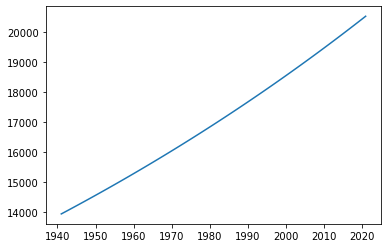

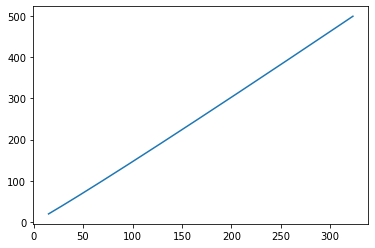

    100-year flood  200-year flood  500-year flood  1000-year flood
0       100.000000      200.000000      500.000000      1000.000000
1        96.340196      192.068963      478.303737       953.969254
2        92.830805      184.485573      457.632159       910.224095
3        89.465115      177.233412      437.933579       868.643978
4        86.236730      170.296886      419.159068       829.115049
5        83.139561      163.661184      401.262295       791.529754
6        80.167808      157.312231      384.199383       755.786478
7        77.315944      151.236653      367.928777       721.789197
8        74.578704      145.421742      352.411108       689.447162
9        71.951069      139.855418      337.609078       658.674592
10       69.428256      134.526194      323.487345       629.390391
11       67.005705      129.423153      310.012413       601.517878
12       64.679072      124.535911      297.152532       574.984540
13       62.444209      119.854592      284.8776

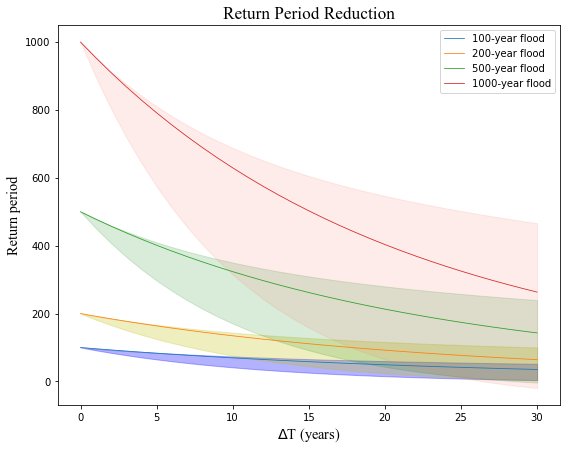

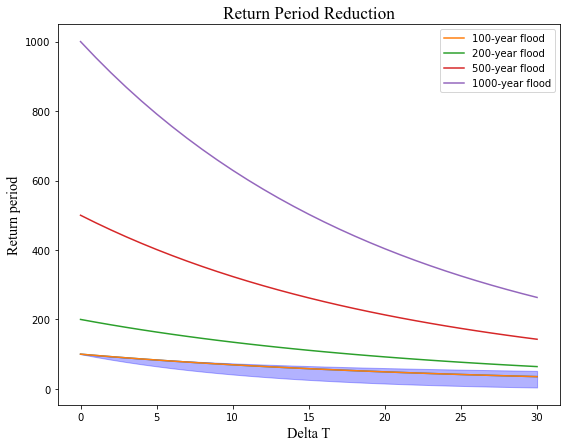

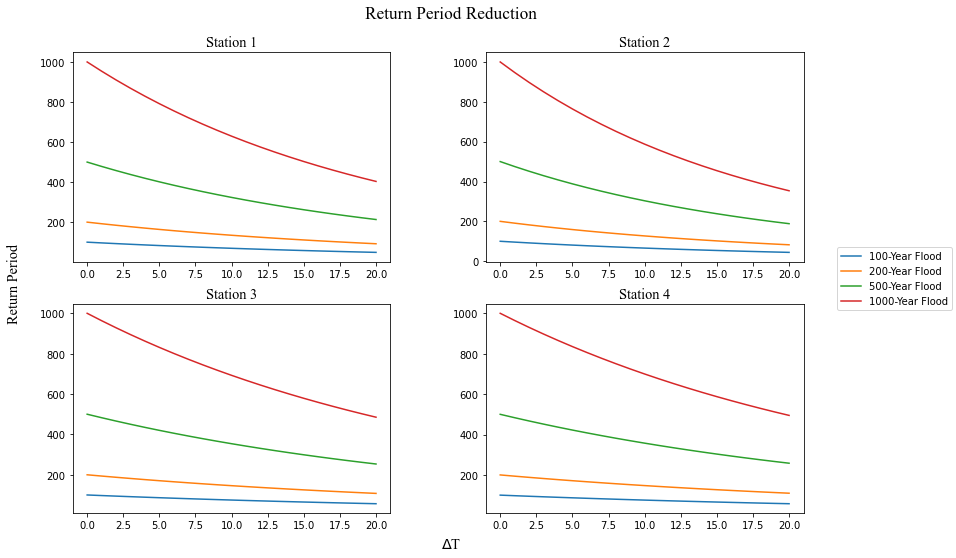

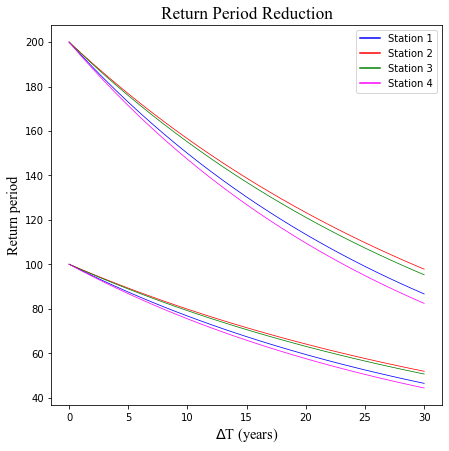

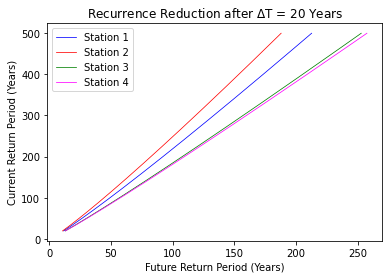

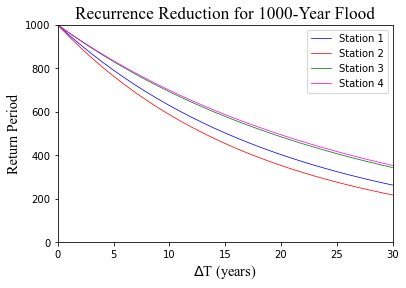

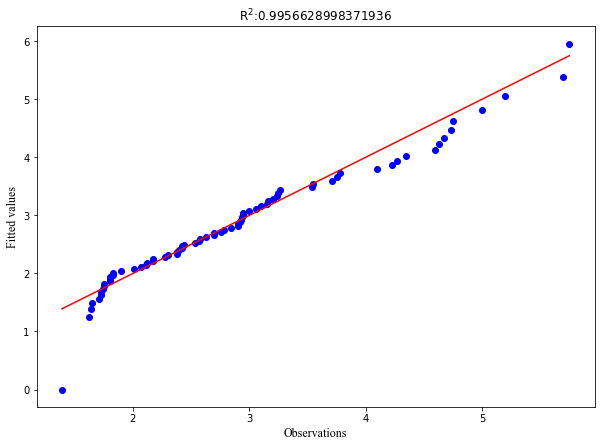

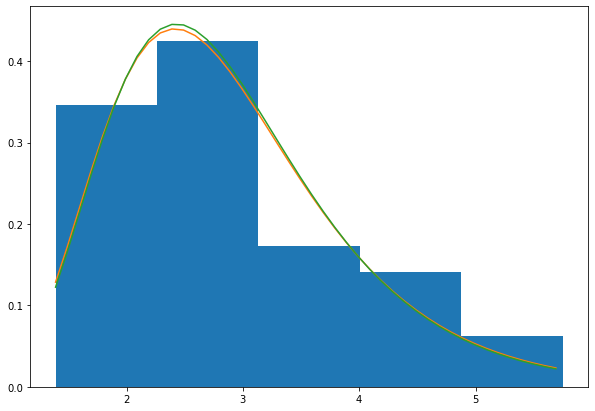

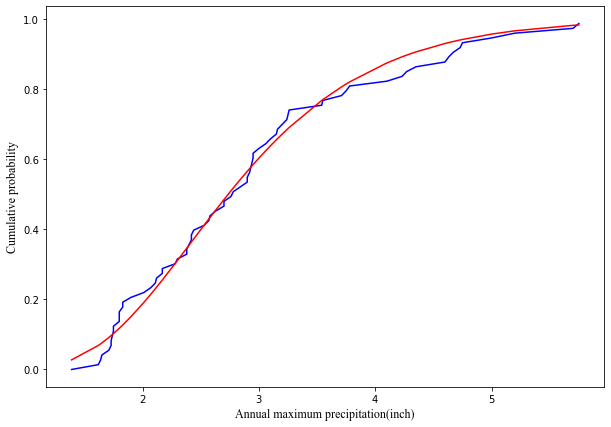

importing Jupyter notebook from Fall_trend_test.ipynb


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats as ss
import scipy.signal
from astropy.stats import bootstrap as bootstrap
from statsmodels.tsa.ar_model import AutoReg
import math
import common_func as cf
import import_ipynb
from Vogel import find_trend as ft
import check_ln2

import Fall_trend_test as Fall

In [6]:

#MannKendall Test

# function for determining tie groups and corresponding number of ties.
def count_ties(x):
    ties = []
    y = x
    while len(x) > 0: 
        ties.append(np.where(x == x[0])[0].size)
        x = np.delete(x, np.where(x == x[0]))
    ties=np.array(ties)
    return ties

#function for calculating variance in mann kendall test
def var(x):
    n = len(x)
    var = n * (n - 1) * (2 * n + 5)
    e = count_ties(x)
    extent_sum = np.sum(e * (e - 1) * (2 * e + 5))
    return  (var - extent_sum)/18

# function for testing pvalue and critical value of mann kendall test
def mktest(z):
    alpha = 0.05    # alpha = 0.1 
    CritVal = np.abs(ss.norm.ppf(alpha / 2))
    pvalue = ss.norm.sf(np.abs(z)) * 2 
    print('pvalue:',pvalue)
# Reject H0 if |Z-Score| > CritVal and, equivalently, if p-value < alpha/2
    reject1 = CritVal < np.abs(z)
    reject2 = pvalue < alpha
    if reject1:
        return 'Yes'
    return 'No'
# Mann Kendall Test
def main_mk(maxQ):
    T = 0
    data = np.log(maxQ)
    for j in range(len(data)-1):
        t = data[j] - (data[j+1:])
        T += (np.where(t < 0))[0].size - (np.where(t > 0))[0].size
    variance = var(data)
    if T > 0:
        z = (T - 1)/(np.sqrt(variance))
    else:
        z = (T + 1)/(np.sqrt(variance))
    print('Z_value:',z)
    trend = mktest(z)
    print('Is there a monotonic trend?',trend,'\n')

In [7]:
def acf_pacf(maxQ):
    sm.graphics.tsa.plot_acf(np.log(maxQ))
    plt.show()
    sm.graphics.tsa.plot_pacf(np.log(maxQ))
    plt.show()

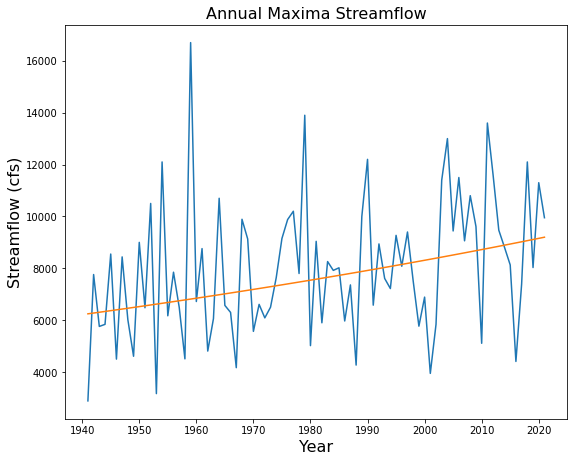

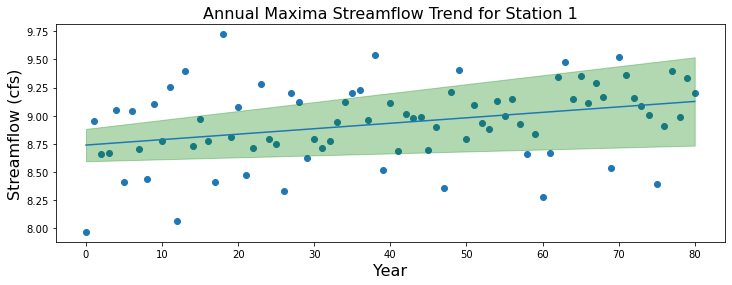

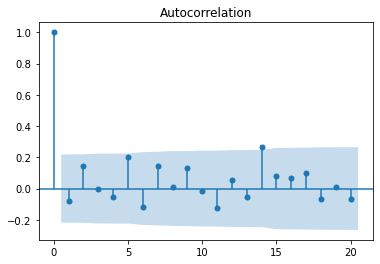

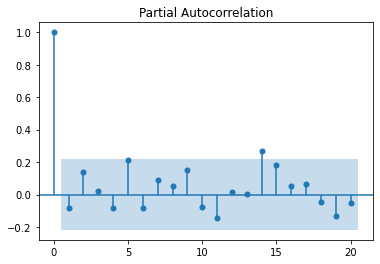

Z_value: 3.164922437485291
pvalue: 0.0015512429702231592
Is there a monotonic trend? Yes 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     9.648
Date:                Wed, 09 Mar 2022   Prob (F-statistic):            0.00263
Time:                        12:37:45   Log-Likelihood:                -23.593
No. Observations:                  81   AIC:                             51.19
Df Residuals:                      79   BIC:                             55.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [12]:
# Streamflow data: Stations 1-4: 
# Stations = ['station_04208000.csv','station_04196800.csv','station_04195500.csv','station_03117000.csv']

Data = pd.read_csv('station_04208000.csv')
maxQ, yearMaxQ = cf.annual_max(Data)
###FALL
# maxQ, yearMaxQ = Fall.Fall_max(Data)

#Using Index years
yearMaxQ = np.arange(0,len(yearMaxQ),1) 

#OLS regression: 
lr = ft(np.log(maxQ), yearMaxQ)
#Trend Line: 
beta = lr.params[1]
interc = lr.params[0]
y = beta*yearMaxQ+interc
# Confidence Interval:
CI = lr.conf_int(alpha=0.05)
#higher CI:
beta_H = CI[1][1]
interc_H = CI[0][1]
yH = beta_H*yearMaxQ + interc_H
#Lower CI: 
beta_L = CI[1][0]
interc_L = CI[0][0]
yL = beta_L*yearMaxQ + interc_L


# Annual Max Plot: 
fig = plt.figure()
plt.plot(yearMaxQ, maxQ)
plt.plot(yearMaxQ,np.exp(y))
#Changes the ticks to years, but is specific to Station 1 right now...
plt.xticks([0-1, 10-1, 20-1, 30-1, 40-1, 50-1, 60-1, 70-1, 80-1], ['1940', '1950', '1960', '1970','1980', '1990','2000', '2010','2020'])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Streamflow (cfs)', fontsize=16)
plt.title('Annual Maxima Streamflow', fontsize=16)
fig.set_size_inches([9, 7.25])
fig.savefig('Annual_Streamflow', dpi=300)
plt.savefig('Annual_Streamflow.svg')
plt.show()

#Annual Maxima with trend line plot: 
fig = plt.figure()
plt.scatter(yearMaxQ, np.log(maxQ))
plt.plot(yearMaxQ,y)
plt.fill_between(yearMaxQ, (y+(yH-y)), (y-(y-yL)), color='g', alpha=.3)
#Changes the ticks to years, but is specific to Station 1 right now...
# plt.xticks([0-1, 10-1, 20-1, 30-1, 40-1, 50-1, 60-1, 70-1, 80-1], ['1940', '1950', '1960', '1970','1980', '1990','2000', '2010','2020'])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Streamflow (cfs)', fontsize=16)
plt.title('Annual Maxima Streamflow Trend for Station 1', fontsize=16)
fig.set_size_inches([12, 4])
fig.savefig('Annual_streamflow_CI', dpi=300)
plt.savefig('Annual_streamflow_CI.svg')
plt.show()


#TESTS
# m = check_ln2.qq_plot(maxQ)
acf_pacf(maxQ)
main_mk(maxQ)
lr = ft(np.log(maxQ), yearMaxQ)
print(lr.summary())


In [5]:
#For all stations: 
Stations = ['station_04208000.csv','station_04196800.csv','station_04195500.csv','station_03117000.csv']

# Mean flow and sigma
for s in Stations:
    data = pd.read_csv(s)
    maxQ, years = cf.annual_max(data)
    ybar,std, skew = cf.findmoments(maxQ)
    print(s + ' Mean: ' + str(ybar) + ' Sigma: ' + str(std))

station_04208000.csv Mean: 8018.888888888889 Sigma: 2658.653794686326
station_04196800.csv Mean: 3740.877192982456 Sigma: 1381.5290192673096
station_04195500.csv Mean: 6645.243902439024 Sigma: 2391.939254363977
station_03117000.csv Mean: 4416.626506024097 Sigma: 1463.6466962638167
